In [651]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [652]:
piece = 'Chambre'
id = 6569

In [653]:
ref = cv2.imread(f'Images/{piece}/Reference.JPG')
image = cv2.imread(f'Images/{piece}/IMG_{id}.JPG')
image_contours = image.copy()

In [654]:
def get_mask():
    mask = np.zeros_like(image)
    if piece == 'Chambre':
        ROI= np.array([
            [3176, 792],
            [5544, 2172],
            [3584, 3912],
            [1287, 2136]
        ], np.int32)
    elif piece == 'Cuisine':
        ROI = np.array([
            [1100, 3999],
            [2000, 2000],
            [3600, 2000],
            [4500, 3999]
        ], np.int32)
    elif piece == 'Salon':
        ROI = np.array([
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0]
        ], np.int32)
    else:
        raise ValueError('@param piece must be one of the following: Chambre, Cuisine, Salon')
    
    cv2.fillPoly(mask, [ROI], (255, 255, 255))
    return mask, ROI

In [655]:
ref = cv2.bitwise_and(ref, get_mask()[0])
image = cv2.bitwise_and(image, get_mask()[0])

In [656]:
ref_LAB = cv2.cvtColor(ref, cv2.COLOR_BGR2LAB)
ref_HSV = cv2.cvtColor(ref, cv2.COLOR_BGR2HSV)
image_LAB = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
image_HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

In [657]:
ref_L, ref_A, ref_B = cv2.split(ref_LAB)
ref_H, ref_S, ref_V = cv2.split(ref_HSV)
image_L, image_A, image_B = cv2.split(image_LAB)
image_H, image_S, image_V = cv2.split(image_HSV)

In [658]:
diff_L = cv2.absdiff(ref_L, image_L)
diff_A = cv2.absdiff(ref_A, image_A)
diff_B = cv2.absdiff(ref_B, image_B)
diff_H = cv2.absdiff(ref_H, image_H)
diff_S = cv2.absdiff(ref_S, image_S)
diff_V = cv2.absdiff(ref_V, image_V)

In [659]:
diff = diff_L*0.1 + diff_A*0.3 + diff_B*0.3 + diff_H*0.4 + diff_S*0.2
diff = cv2.convertScaleAbs(diff)

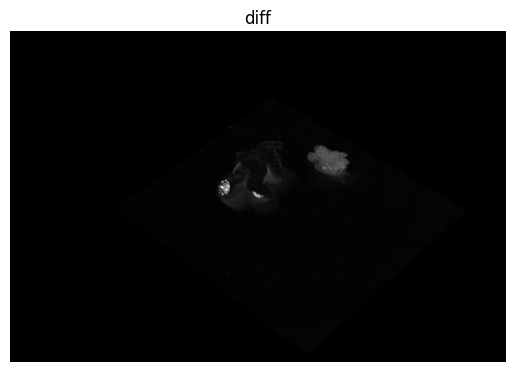

In [660]:
plt.imshow(diff, cmap='gray')
plt.axis('off')
plt.title('diff')
plt.show()

In [661]:
T, _ = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
T

19.0

In [662]:
_, diff_thresh = cv2.threshold(diff, int(T*0.9), 255, cv2.THRESH_BINARY)

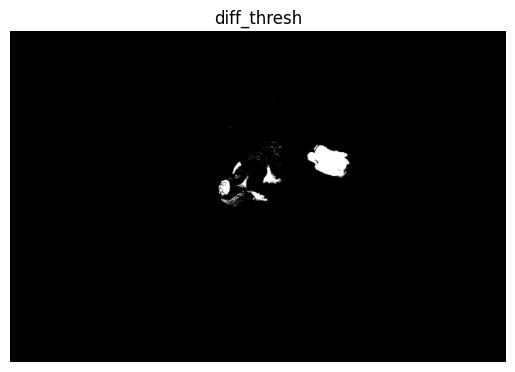

In [663]:
plt.imshow(diff_thresh, cmap='gray')
plt.axis('off')
plt.title('diff_thresh')
plt.show()

In [664]:
kernel = np.ones((25, 25), np.uint8)
diff_thresh = cv2.morphologyEx(diff_thresh, cv2.MORPH_CLOSE, kernel)
diff_thresh = cv2.morphologyEx(diff_thresh, cv2.MORPH_OPEN, kernel)
diff_thresh = cv2.dilate(diff_thresh, kernel, iterations=2)
diff_thresh = cv2.morphologyEx(diff_thresh, cv2.MORPH_CLOSE, kernel)
diff_thresh = cv2.dilate(diff_thresh, kernel, iterations=2)
diff_thresh = cv2.morphologyEx(diff_thresh, cv2.MORPH_CLOSE, kernel)

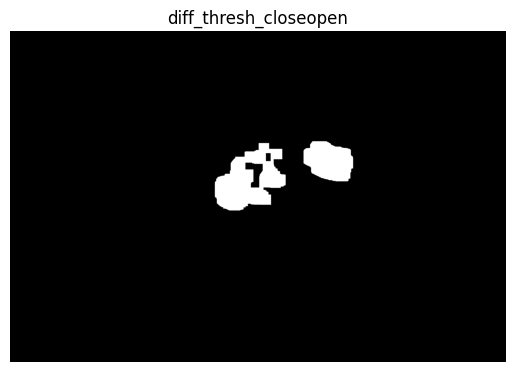

In [665]:
plt.imshow(diff_thresh, cmap='gray')
plt.axis('off')
plt.title('diff_thresh_closeopen')
plt.show()

In [666]:
contours, _ = cv2.findContours(diff_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [667]:
contours = [contour for contour in contours if cv2.contourArea(contour) > 1000]

In [668]:
# draw contours
image_contours = cv2.drawContours(image_contours, contours, -1, (0, 255, 0), 2)

In [669]:
# draw bounding boxes
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image_contours, (x, y), (x+w, y+h), (0, 0, 255), 5)

In [670]:
# draw ROI
image_contours = cv2.polylines(image_contours, [get_mask()[1]], True, (255, 0, 0), 3)

In [671]:
cv2.imshow(f'image_contours_{id}', cv2.resize(image_contours, (0, 0), fx=0.2, fy=0.2))
cv2.waitKey(0)

-1